# Class Project

### Use the put/call ratio to predict the future stock price for JPM

Using a Random Forest model to predict future stock price

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation

#for data visualization 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

#make it so that we only show first 4 decimals for floats
np.set_printoptions(precision=4,suppress=True)

C:\Users\Tanshi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read data into a DataFrame
def get_stockdata(symbol):
    df = None
    if symbol == 'SPY':
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv",index_col=['Date'], usecols=['Date','Close','Volume'])  
        df.columns = ['close','vol']
        return df
    if symbol == 'VIX':
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv",index_col=['Date'], usecols=['Date','Close'])  
        df.columns = ['VIX_close']
        return df
    if symbol == 'SPX_PC':
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv",index_col=['DATE'], usecols=['DATE','P/C Ratio'])  
        df.columns = ['put_call_ratio']
        return df
    if symbol not in ['SPY','VIX']:
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv",index_col=['Date'],usecols=['Date','Adj Close','Volume'])
        df.columns = ['close','vol']
        return df

In [3]:
# Read csv data in dataframe
stock_data = get_stockdata('JPM') # Predict future price of this stock 'JPM'
# stock_data = stock_data.sort_index()
SPY_data = get_stockdata('SPY') # S&P 500 - gives direction of overall market
# SPY_data = SPY_data.sort_index()
VIX_data = get_stockdata('VIX') # Volatility index of S&P 500
# VIX_data = VIX_data.sort_index()
Put_Call_data = get_stockdata('SPX_PC') # put call ratio of S&P 500
# Put_Call_data = Put_Call_data.sort_index()

In [4]:
# Prediction of future stock price on n'th day
days_to_forecast_forward = 5

In [5]:
stock_data.index = stock_data.index.map(lambda x: pd.to_datetime(x))
SPY_data.index = SPY_data.index.map(lambda x: pd.to_datetime(x))
VIX_data.index = VIX_data.index.map(lambda x: pd.to_datetime(x))
Put_Call_data.index = Put_Call_data.index.map(lambda x: pd.to_datetime(x))

In [6]:
#merge the data in one table
stock_data = stock_data.join(SPY_data, how="inner", rsuffix="_SPY")
stock_data = stock_data.join(VIX_data, how="inner")
stock_data = stock_data.join(Put_Call_data, how="left")

stock_data = stock_data.sort_index(ascending=True)


In [7]:
# Target variable 'y' is the stock price after certain days = n days

stock_data["future_date"]=pd.datetime(1990,1,1) # Initialize
stock_data.future_date[:-days_to_forecast_forward] = stock_data.index[days_to_forecast_forward:]

stock_data["observed_price"]=-1 # Initialize
stock_data.observed_price[:-days_to_forecast_forward] = stock_data["close"][days_to_forecast_forward:]

#note: date of 1900-01-01 and future price of -1 signifies the lack of sufficient prod data

C:\Users\Tanshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Tanshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [8]:
print (stock_data.dtypes)
stock_data[-10:].head()

close                    float64
vol                        int64
close_SPY                float64
vol_SPY                    int64
VIX_close                float64
put_call_ratio           float64
future_date       datetime64[ns]
observed_price           float64
dtype: object


,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,observed_price
Date,,,,,,,,
2018-06-18,108.180000,9786800,276.559998,52917600,12.31,1.58,2018-06-25,104.790001
2018-06-19,107.550003,12707200,275.500000,97531500,13.35,0.85,2018-06-26,104.860001
2018-06-20,107.540001,8876900,275.970001,53785500,12.79,1.38,2018-06-27,103.239998
2018-06-21,107.510002,11048700,274.239990,71061400,14.64,1.30,2018-06-28,104.930000
2018-06-22,105.750000,19478900,274.739990,54898500,13.77,1.25,2018-06-29,104.199997


In [9]:
stock_data[-days_to_forecast_forward-1:].tail()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,observed_price
Date,,,,,,,,
2018-06-25,104.790001,16907600,271.000000,137854200,17.33,1.17,1990-01-01,-1.0
2018-06-26,104.860001,17086800,271.600006,68547400,15.92,1.19,1990-01-01,-1.0
2018-06-27,103.239998,16276800,269.350006,105110700,17.91,1.25,1990-01-01,-1.0
2018-06-28,104.930000,14491300,270.890015,76650500,16.85,1.31,1990-01-01,-1.0
2018-06-29,104.199997,18941500,271.279999,97524300,16.09,1.64,1990-01-01,-1.0


In [10]:
# Features variables X
stock_data["daily_return"]=0.000000001
stock_data["daily_return"][1:]=np.log(stock_data["close"][1:]/stock_data["close"][:-1].values)  #- 1

C:\Users\Tanshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
stock_data["daily_return"].tail()


Date
2018-06-25   -0.009119
2018-06-26    0.000668
2018-06-27   -0.015570
2018-06-28    0.016237
2018-06-29   -0.006981
Name: daily_return, dtype: float64

In [12]:
# Calculate rolling stats of 'close' price using window size of n days

stock_data["rolling_mean"] = stock_data.close.rolling(window=days_to_forecast_forward, center=False).mean()
stock_data["rolling_std"] = stock_data.close.rolling(window=days_to_forecast_forward, center=False).std()
stock_data["rolling_mean"].fillna(0, inplace = True)
stock_data["rolling_std"].fillna(0, inplace = True)

In [13]:
# One of the features used - "Bollinger Bands"
# A simple way to interpret in our case -- buy when price touches the lower Bollinger Band and exit when price touches the moving average in the center of the bands. 
def get_bollinger_bands(x):
    upper_band, lower_band = x["rolling_mean"] + 2*x["rolling_std"], x["rolling_mean"] - 2*x["rolling_std"]
    return upper_band, lower_band

In [14]:
stock_data["bollinger_band"]=stock_data[["rolling_mean","rolling_std"]].apply(get_bollinger_bands,axis=1)
stock_data["upper_bollinger_band"]=stock_data["bollinger_band"].apply(lambda x: x[0])
stock_data["lower_bollinger_band"]=stock_data["bollinger_band"].apply(lambda x: x[1])
stock_data = stock_data.drop("bollinger_band", axis = 1)

In [15]:
# Backfill put_call_ratio (with first known value)
stock_data.fillna(method="bfill",inplace=True)

In [16]:
stock_data.head()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,observed_price,daily_return,rolling_mean,rolling_std,upper_bollinger_band,lower_bollinger_band
Date,,,,,,,,,,,,,
2006-11-01,35.236969,11490200,136.860001,83005600,11.51,1.25,2006-11-08,35.770069,1.000000e-09,0.000000,0.000000,0.00000,0.000000
2006-11-02,35.214451,7059000,136.779999,60693100,11.42,1.12,2006-11-09,35.469730,-6.392490e-04,0.000000,0.000000,0.00000,0.000000
2006-11-03,35.206947,7984100,136.539993,71346400,11.16,1.26,2006-11-10,35.747540,-2.131170e-04,0.000000,0.000000,0.00000,0.000000
2006-11-06,35.777580,8633700,138.080002,63303300,11.16,1.26,2006-11-13,35.785076,1.607802e-02,0.000000,0.000000,0.00000,0.000000
2006-11-07,35.657448,8535500,138.610001,63318900,11.09,1.04,2006-11-14,35.852650,-3.363395e-03,35.418679,0.276305,35.97129,34.866068


In [17]:
stock_data = stock_data[stock_data.columns.tolist()[0:6]+stock_data.columns.tolist()[8:]+stock_data.columns.tolist()[6:8]]
stock_data.columns.tolist()

['close',
 'vol',
 'close_SPY',
 'vol_SPY',
 'VIX_close',
 'put_call_ratio',
 'daily_return',
 'rolling_mean',
 'rolling_std',
 'upper_bollinger_band',
 'lower_bollinger_band',
 'future_date',
 'observed_price']

In [18]:
stock_data.head()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,daily_return,rolling_mean,rolling_std,upper_bollinger_band,lower_bollinger_band,future_date,observed_price
Date,,,,,,,,,,,,,
2006-11-01,35.236969,11490200,136.860001,83005600,11.51,1.25,1.000000e-09,0.000000,0.000000,0.00000,0.000000,2006-11-08,35.770069
2006-11-02,35.214451,7059000,136.779999,60693100,11.42,1.12,-6.392490e-04,0.000000,0.000000,0.00000,0.000000,2006-11-09,35.469730
2006-11-03,35.206947,7984100,136.539993,71346400,11.16,1.26,-2.131170e-04,0.000000,0.000000,0.00000,0.000000,2006-11-10,35.747540
2006-11-06,35.777580,8633700,138.080002,63303300,11.16,1.26,1.607802e-02,0.000000,0.000000,0.00000,0.000000,2006-11-13,35.785076
2006-11-07,35.657448,8535500,138.610001,63318900,11.09,1.04,-3.363395e-03,35.418679,0.276305,35.97129,34.866068,2006-11-14,35.852650


In [19]:
#features for scaling
scaling_features = stock_data.columns.tolist()[:-2]
print (scaling_features)

['close', 'vol', 'close_SPY', 'vol_SPY', 'VIX_close', 'put_call_ratio', 'daily_return', 'rolling_mean', 'rolling_std', 'upper_bollinger_band', 'lower_bollinger_band']


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #create a scaler object
X = stock_data[scaling_features]
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=["scaled_"+i for i in scaling_features])

In [21]:
stock_data.iloc[:23]
stock_data.head()
X_scaled.head()

,scaled_close,scaled_vol,scaled_close_SPY,scaled_vol_SPY,scaled_VIX_close,scaled_put_call_ratio,scaled_daily_return,scaled_rolling_mean,scaled_rolling_std,scaled_upper_bollinger_band,scaled_lower_bollinger_band
0,-0.597408,-0.759936,-0.553356,-0.752859,-0.846113,0.160142,-0.014221,-2.169855,-1.356963,-2.216773,-2.117843
1,-0.598416,-0.952946,-0.554950,-0.971260,-0.855554,-0.255407,-0.038830,-2.169855,-1.356963,-2.216773,-2.117843
2,-0.598752,-0.912652,-0.559731,-0.866982,-0.882829,0.192108,-0.022425,-2.169855,-1.356963,-2.216773,-2.117843
3,-0.573206,-0.884357,-0.529051,-0.945710,-0.882829,0.192108,0.604724,-2.169855,-1.356963,-2.216773,-2.117843
4,-0.578584,-0.888634,-0.518493,-0.945558,-0.890172,-0.511129,-0.143699,-0.584798,-0.819226,-0.618155,-0.549820


In [22]:
# Vertical merge the scaled data with original
stock_data = stock_data.reset_index()   #To retain the index , which corresponds to Date column
stock_data=pd.concat([X_scaled,stock_data],axis=1)

In [23]:
stock_data.index
print (stock_data.head(5))
stock_data.columns.tolist()

   scaled_close  scaled_vol  scaled_close_SPY  scaled_vol_SPY  \
0     -0.597408   -0.759936         -0.553356       -0.752859   
1     -0.598416   -0.952946         -0.554950       -0.971260   
2     -0.598752   -0.912652         -0.559731       -0.866982   
3     -0.573206   -0.884357         -0.529051       -0.945710   
4     -0.578584   -0.888634         -0.518493       -0.945558   

   scaled_VIX_close  scaled_put_call_ratio  scaled_daily_return  \
0         -0.846113               0.160142            -0.014221   
1         -0.855554              -0.255407            -0.038830   
2         -0.882829               0.192108            -0.022425   
3         -0.882829               0.192108             0.604724   
4         -0.890172              -0.511129            -0.143699   

   scaled_rolling_mean  scaled_rolling_std  scaled_upper_bollinger_band  \
0            -2.169855           -1.356963                    -2.216773   
1            -2.169855           -1.356963              

['scaled_close',
 'scaled_vol',
 'scaled_close_SPY',
 'scaled_vol_SPY',
 'scaled_VIX_close',
 'scaled_put_call_ratio',
 'scaled_daily_return',
 'scaled_rolling_mean',
 'scaled_rolling_std',
 'scaled_upper_bollinger_band',
 'scaled_lower_bollinger_band',
 'Date',
 'close',
 'vol',
 'close_SPY',
 'vol_SPY',
 'VIX_close',
 'put_call_ratio',
 'daily_return',
 'rolling_mean',
 'rolling_std',
 'upper_bollinger_band',
 'lower_bollinger_band',
 'future_date',
 'observed_price']

In [24]:
# set index 
stock_data = stock_data.set_index('Date')

In [25]:
print (stock_data.index.max(), stock_data.index.min())

2018-06-29 00:00:00 2006-11-01 00:00:00


In [26]:
# Create a deep copy of stock_data & strip data at both ends according to "days_to_forecast_forward"
master_stock_data = stock_data.copy()
columns_replaced_with_underscores= [np.str.replace(i," ","_") for i in master_stock_data.columns.tolist()]
master_stock_data = master_stock_data[columns_replaced_with_underscores]
master_stock_data = master_stock_data[days_to_forecast_forward - 1:-days_to_forecast_forward]

In [27]:
stock_data[16:].head()
master_stock_data.head()

,scaled_close,scaled_vol,scaled_close_SPY,scaled_vol_SPY,scaled_VIX_close,scaled_put_call_ratio,scaled_daily_return,scaled_rolling_mean,scaled_rolling_std,scaled_upper_bollinger_band,...,vol_SPY,VIX_close,put_call_ratio,daily_return,rolling_mean,rolling_std,upper_bollinger_band,lower_bollinger_band,future_date,observed_price
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-07,-0.578584,-0.888634,-0.518493,-0.945558,-0.890172,-0.511129,-0.143699,-0.584798,-0.819226,-0.618155,...,63318900,11.09,1.04,-0.003363,35.418679,0.276305,35.971290,34.866068,2006-11-14,35.852650
2006-11-08,-0.573542,-0.933250,-0.512516,-0.708692,-0.925839,-0.670956,0.107175,-0.580026,-0.790400,-0.612100,...,87517800,10.75,0.99,0.003153,35.525299,0.291117,36.107533,34.943065,2006-11-15,35.627415
2006-11-09,-0.586988,-0.962629,-0.527059,-0.626486,-0.898564,0.703552,-0.338815,-0.577741,-0.887835,-0.614281,...,95916300,11.01,1.42,-0.008432,35.576355,0.241052,36.058458,35.094251,2006-11-16,35.927731
2006-11-10,-0.574550,-1.005611,-0.525864,-1.085798,-0.921643,-0.063615,0.286120,-0.572903,-1.105429,-0.619414,...,48991500,10.79,1.18,0.007802,35.684473,0.129246,35.942965,35.425982,2006-11-17,35.785076
2006-11-13,-0.572870,-0.926568,-0.519090,-0.983935,-0.914299,0.511761,0.026180,-0.572836,-1.102731,-0.619224,...,59398200,10.86,1.36,0.001049,35.685973,0.130632,35.947236,35.424709,2006-11-20,35.965290


In [28]:
# Split entire data in test/train data and production data
prod_never_seen_window = 90

# Strip test_train data and prod data according to "days_to_forecast_forward"
never_seen_data = master_stock_data[-prod_never_seen_window:]
test_train_data = master_stock_data[:-prod_never_seen_window]

In [29]:
never_seen_data.shape
test_train_data.shape

(2836, 24)

In [30]:
# Stock features
X_scaled_features = [i for i in test_train_data.columns.tolist() if 'scaled' in i]
print (X_scaled_features)

['scaled_close', 'scaled_vol', 'scaled_close_SPY', 'scaled_vol_SPY', 'scaled_VIX_close', 'scaled_put_call_ratio', 'scaled_daily_return', 'scaled_rolling_mean', 'scaled_rolling_std', 'scaled_upper_bollinger_band', 'scaled_lower_bollinger_band']


In [31]:
# Stock features & target
X = test_train_data[X_scaled_features]
y = test_train_data.observed_price
prod_X = never_seen_data[X_scaled_features]

In [32]:
# Stock features & target
print ("Using LinearRegression to predict")
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=234)
print ("training data size:",X_train.shape)
print ("testing data size:",X_test.shape)
#train on training set
mult_linreg = LinearRegression()
mult_linreg.fit(X_train, y_train)

#generate predictions on test set and evaluate
y_mult_pred_test = mult_linreg.predict(X_test)
print ("Prediction set RMSE:",np.sqrt(np.abs(metrics.mean_squared_error(y_test, y_mult_pred_test))))

Using LinearRegression to predict
training data size: (2552, 11)
testing data size: (284, 11)
Prediction set RMSE: 1.6073799852540644


In [33]:
never_seen_data_prediction = mult_linreg.predict(prod_X)
print ("never_seen_data_prediction - RMSE:",np.sqrt(np.abs(mean_squared_error(never_seen_data.observed_price,never_seen_data_prediction))))

# Add new column predictor to never_seen_data (with least RMSE)
never_seen_data["predicted_price"]=never_seen_data_prediction

never_seen_data_prediction - RMSE: 3.1464311373301723


C:\Users\Tanshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [34]:
# Plotting graph with x="future_date", and y = ["observed_price","prediction_close"]
df = never_seen_data[['future_date','observed_price','predicted_price']]
df = df.reset_index()
df.head()

,Date,future_date,observed_price,predicted_price
0,2018-02-14,2018-02-22,114.399872,114.410958
1,2018-02-15,2018-02-23,116.718117,115.119006
2,2018-02-16,2018-02-26,118.170746,114.560272
3,2018-02-20,2018-02-27,116.767860,114.694808
4,2018-02-21,2018-02-28,114.917252,114.993431


In [35]:
df = df.set_index('future_date')
df.head()

,Date,observed_price,predicted_price
future_date,,,
2018-02-22,2018-02-14,114.399872,114.410958
2018-02-23,2018-02-15,116.718117,115.119006
2018-02-26,2018-02-16,118.170746,114.560272
2018-02-27,2018-02-20,116.767860,114.694808
2018-02-28,2018-02-21,114.917252,114.993431


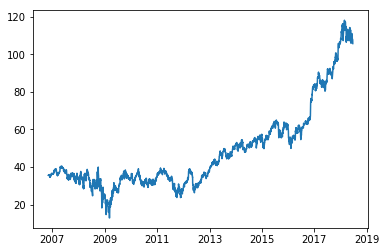

In [36]:
# Plot of entire data
plt.plot(master_stock_data['close'])

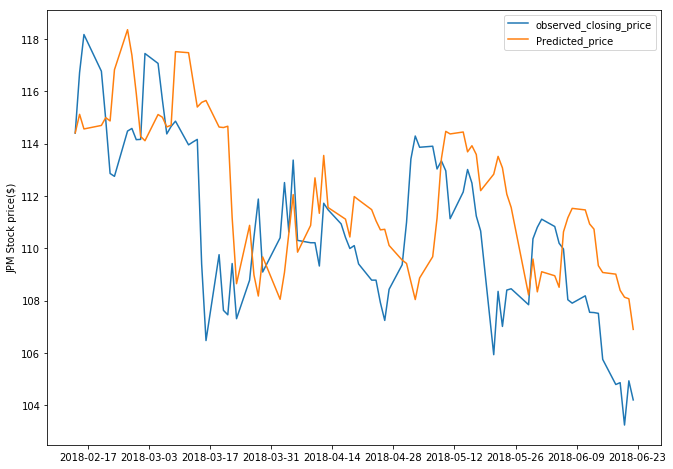

In [37]:
fig, ax = plt.subplots(figsize=(11,8))
ax.plot(never_seen_data.index, never_seen_data.observed_price, label='observed_closing_price')
ax.plot(never_seen_data.index, never_seen_data.predicted_price, label='Predicted_price')
ax.set_ylabel("JPM Stock price($)")
ax.legend()

In [38]:
mult_feature_cols = prod_X.columns.tolist()
feature_importance= pd.DataFrame(list(zip(mult_feature_cols, mult_linreg.coef_)), columns=["Features","Coefficient"])

In [39]:
feature_importance.sort_values("Coefficient",inplace=True, ascending=False)

In [40]:
feature_importance

,Features,Coefficient
0,scaled_close,17.125479
10,scaled_lower_bollinger_band,1.719273
7,scaled_rolling_mean,1.715312
9,scaled_upper_bollinger_band,1.707856
2,scaled_close_SPY,0.300974
1,scaled_vol,0.243729
8,scaled_rolling_std,0.097349
5,scaled_put_call_ratio,-0.013849
4,scaled_VIX_close,-0.052232
6,scaled_daily_return,-0.067757


## Random Forest Regression on the same data set

### Using Random Forest Regression to predict close price of the stock 5 days into the future

In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

#Random forest of 500 trees
rf = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=1)
rf.fit(X_train, y_train)
y_prediction_rf = rf.predict(X_test)
    
print("Random Forest RMSE on Test Data:",np.sqrt(mean_squared_error(y_test, y_prediction_rf)))

Random Forest RMSE on Test Data: 1.3553839167741826


In [42]:
never_seen_data_preds_rf = rf.predict(prod_X)
print("Random Forest RMSE on Production Data:",np.sqrt(mean_squared_error(never_seen_data.observed_price, never_seen_data_preds_rf)))

# Add new column predictor to never_seen_data (with least RMSE)
never_seen_data["predicted_price_rf"]=never_seen_data_preds_rf

Random Forest RMSE on Production Data: 3.872511391682481


C:\Users\Tanshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [43]:
# Plotting graph with x="future_date", and y = ["observed_price","prediction_close"]
df = never_seen_data[['future_date','observed_price','predicted_price','predicted_price_rf']]
df = df.reset_index()
df.head()

,Date,future_date,observed_price,predicted_price,predicted_price_rf
0,2018-02-14,2018-02-22,114.399872,114.410958,114.465400
1,2018-02-15,2018-02-23,116.718117,115.119006,113.739998
2,2018-02-16,2018-02-26,118.170746,114.560272,113.742903
3,2018-02-20,2018-02-27,116.767860,114.694808,114.187587
4,2018-02-21,2018-02-28,114.917252,114.993431,112.652930


In [44]:
df = df.set_index('future_date')
df.head()

,Date,observed_price,predicted_price,predicted_price_rf
future_date,,,,
2018-02-22,2018-02-14,114.399872,114.410958,114.465400
2018-02-23,2018-02-15,116.718117,115.119006,113.739998
2018-02-26,2018-02-16,118.170746,114.560272,113.742903
2018-02-27,2018-02-20,116.767860,114.694808,114.187587
2018-02-28,2018-02-21,114.917252,114.993431,112.652930


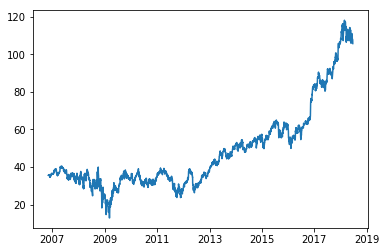

In [45]:
# Plot of entire data
plt.plot(master_stock_data['close'])

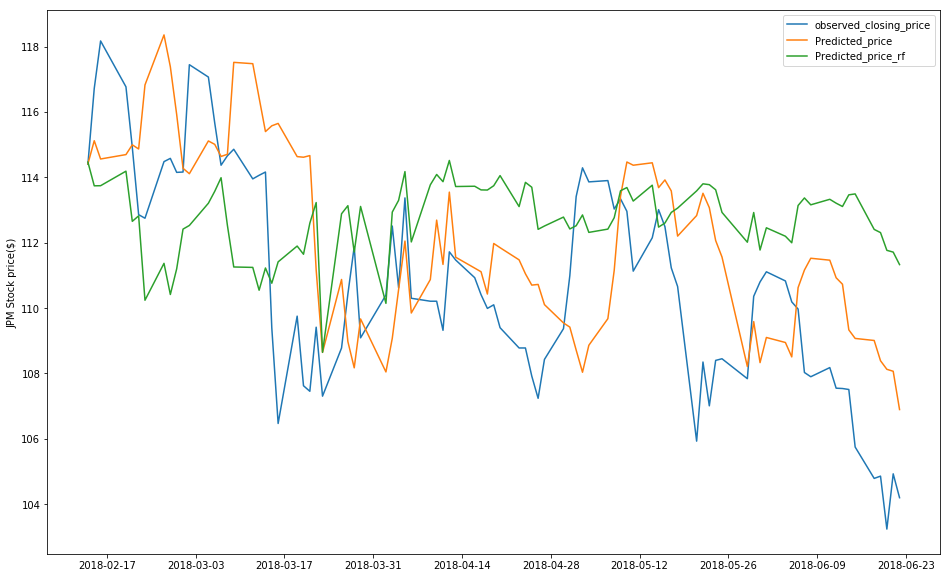

In [46]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(never_seen_data.index, never_seen_data.observed_price, label='observed_closing_price')
ax.plot(never_seen_data.index, never_seen_data.predicted_price, label='Predicted_price')
ax.plot(never_seen_data.index, never_seen_data.predicted_price_rf, label = 'Predicted_price_rf')
ax.set_ylabel("JPM Stock price($)")
ax.legend()

In [47]:
mult_feature_cols_rf = prod_X.columns.tolist()
feature_importance_rf= pd.DataFrame(list(zip(mult_feature_cols_rf, rf.feature_importances_)), columns=["Features","Feature Importance"])

In [48]:
feature_importance_rf.sort_values("Feature Importance",inplace=True, ascending=False)

In [49]:
feature_importance_rf

,Features,Feature Importance
0,scaled_close,0.621889
7,scaled_rolling_mean,0.203455
10,scaled_lower_bollinger_band,0.077875
9,scaled_upper_bollinger_band,0.057676
2,scaled_close_SPY,0.035659
4,scaled_VIX_close,0.001003
3,scaled_vol_SPY,0.000701
8,scaled_rolling_std,0.000498
1,scaled_vol,0.000447
5,scaled_put_call_ratio,0.000405
